Proyecto Telecom X - Etapa 2 - Machine Learning
---

# Predicción de Evasión (Churn) de clientes.

## Índice

# 1. Descripción del proyecto

En este proyecto se desarrollarán modelos predictivos capaces de prever qué clientes tienen mayor probabilidad de cancelar sus servicios.

La empresa quiere anticiparse al problema de la cancelación explorado en la etapa anterior, por lo que en el presente notebook se construirá un pipeline robusto para esta etapa inicial de modelado, en el cual se llevarán a cabo las siguientes tareas:


* Preparar los datos para el modelado (tratamiento, codificación, normalización).
* Realizar análisis de correlación y selección de variables.
* Entrenar diferentes modelos de clasificación, evaluar el rendimiento de estos a través de distintas métricas e interpretar los resultados de cada uno de ellos.
* Finalmente, se creará un reporte con una conclusión estratégica señalando los principales factores que influyen en la cancelación.

# 2. Importación de librerías y configuraciones

## Importación de librerías

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import requests
from pathlib import Path

import imblearn
from imblearn.under_sampling import NearMiss

from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

## Paths

In [2]:
PROJECT_PATH = 'C:/Users/Ignacio/JupyterScripts/ONE/challenge_telecomX_parte_2'

src = Path('src')
DATA_PATH = PROJECT_PATH / src

img = Path('img')
IMG_PATH = PROJECT_PATH / img

models = Path('models')
MODELS_PATH = PROJECT_PATH / models

reports = Path('Reports')
REPORTS_PATH = PROJECT_PATH / reports


dirs = [DATA_PATH, IMG_PATH, MODELS_PATH, REPORTS_PATH]


for directory in dirs:
    if not directory.exists():
        directory.mkdir(parents=True)
        print(f'Directoryo creado:\n{directory}\n')
    else:
        print(f'El directorio ya existe:\n{directory}\n')

El directorio ya existe:
C:\Users\Ignacio\JupyterScripts\ONE\challenge_telecomX_parte_2\src

El directorio ya existe:
C:\Users\Ignacio\JupyterScripts\ONE\challenge_telecomX_parte_2\img

El directorio ya existe:
C:\Users\Ignacio\JupyterScripts\ONE\challenge_telecomX_parte_2\models

El directorio ya existe:
C:\Users\Ignacio\JupyterScripts\ONE\challenge_telecomX_parte_2\Reports



## Funciones

In [3]:
# Estandarización de colores
sns.set_palette('colorblind')
churn_colors = ['#4682b4', '#e9611d']

In [4]:
def metricas_generales(modelo, 
                       x_val: pd.core.frame.DataFrame,
                       y_val: pd.core.series.Series, 
                       nombre: str):
    """
    Funcion que calcula métricas de modelos clasificación
    ------------------------------------------------------------
    Parámetros:
        modelo:
            Modelo de Machine Learning Scikit-learn (debe contar con el método predict)
        x_val: pandas.core.frame.DataFrame
            DataFrame con las variables explicativas utilizadas para validar el modelo
        y_val: pandas.core.series.Series
            Pandas Series con las etiquetas reales de los datos utilizados para validar el modelo
        nombre: str
            Nombre que identificará el modelo para comparaciones
    ------------------------------------------------------------
    Returns:
        Diccionario con nombre del modelo y metricas: Accuracy, Precision, Recall, F1-score
    """
    
    metricas = {}
    y_pred = modelo.predict(x_val)
    metricas['Model'] = nombre
    metricas['Accuracy'] = np.round(accuracy_score(y_val, y_pred), 4)
    metricas['Precision'] = np.round(precision_score(y_val, y_pred), 4)
    metricas['Recall'] = np.round(recall_score(y_val, y_pred), 4)
    metricas['F1-score'] = np.round(f1_score(y_val, y_pred), 4)

    return metricas

# 3. Preprocesamiento de datos

Para el análisis, incluiré los registros que fueron clasificados como **outliers** en la etapa anterior en la cual se desarrolló la exploración y análisis de la base de datos, ya que en este caso representan comportamientos reales e importantes, como el de clientes con gasto acumulado muy alto que igual abandonan la empresa.

In [5]:
URL = 'https://raw.githubusercontent.com/ignaciomajo/proyecto_TelecomX/refs/heads/main/src/preprocessed_TelecomX_data.json'

datos = pd.read_json(URL)
datos.head()

,CustomerID,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,ChargesDaily,ChargesMonthly,ChargesTotal,Churn
0,0002-ORFBO,Female,No,Yes,Yes,9,Yes,No,DSL,No,...,Yes,Yes,No,One year,Yes,Mailed check,2.19,65.6,593.30,No
1,0003-MKNFE,Male,No,No,No,9,Yes,Yes,DSL,No,...,No,No,Yes,Month-to-month,No,Mailed check,2.00,59.9,542.40,No
2,0004-TLHLJ,Male,No,No,No,4,Yes,No,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Electronic check,2.46,73.9,280.85,Yes
3,0011-IGKFF,Male,Yes,Yes,No,13,Yes,No,Fiber optic,No,...,No,Yes,Yes,Month-to-month,Yes,Electronic check,3.27,98.0,1237.85,Yes
4,0013-EXCHZ,Female,Yes,Yes,No,3,Yes,No,Fiber optic,No,...,Yes,Yes,No,Month-to-month,Yes,Mailed check,2.80,83.9,267.40,Yes


***Nota**: inicialmente, se eliminarán las varialbes `CustomerID` ya que esta no aporta poder predictivo debido a que es un simple identificador de cliente, y `ChargesDaily` ya que esta variable fue agregada simplemente al dividir `ChargesMonthly` en 30 días, lo cual resulta redundante y no aporta ningun valor agregado al análisis.*

In [6]:
try:
    URL = 'https://raw.githubusercontent.com/ignaciomajo/proyecto_TelecomX/refs/heads/main/src/clientes_altovalor_abandonan.json'
    outliers = pd.read_json(URL)
    # Concatenar ambos DafaFrame verticalmente
    datos = pd.concat([datos, outliers], axis=0)
    # Mezclar los datos ya que sino quedaran los outliers ubicados todos al final
    datos = datos.sample(frac=1, random_state=42).reset_index(drop=True)
except Exception as e:
    print('No se encontró el archivo correspondiente, o hubo un problema al cargar los datos')
    print(f'Error: {e}')

In [7]:
datos = datos.drop(['CustomerID', 'ChargesDaily'], axis=1)

## Encoding de variables categóricas

In [8]:
datos.columns

Index(['Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'Tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'ChargesMonthly', 'ChargesTotal', 'Churn'],
      dtype='object')

In [9]:
X = datos.drop('Churn', axis=1)
y = datos['Churn']

In [10]:
categoricas = ['Gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod']

In [11]:
one_hot = make_column_transformer(
                    (OneHotEncoder(drop='if_binary'), categoricas),
                    remainder='passthrough',
                    sparse_threshold=0,
                    force_int_remainder_cols=False
)

label_encoder = LabelEncoder()

In [12]:
X = one_hot.fit_transform(X)

y = label_encoder.fit_transform(y)

In [13]:
y

array([0, 0, 0, ..., 0, 0, 0])

In [14]:
# Mantendré una copia de los array Numpy para al final del proyecto crear Redes Neuronales con PyTorch
X_torch = X.copy()

y_torch = y.copy()

In [15]:
columnas = one_hot.get_feature_names_out()

columnas_encoded = []
for columna in columnas:
    columna = columna.split('__')[1]
    columnas_encoded.append(columna)

In [16]:
df = pd.DataFrame(X, columns=columnas_encoded)
df

,Gender_Male,SeniorCitizen_Yes,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,...,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Tenure,ChargesMonthly,ChargesTotal
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,19.80,19.80
1,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,67.0,60.05,3994.05
2,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,60.0,99.80,5985.75
3,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,35.10,101.10
4,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,63.0,79.85,4861.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7147,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,46.0,19.95,907.05
7148,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,19.15,19.15
7149,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,23.90,97.50
7150,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,19.55,19.55


In [17]:
df_y = pd.DataFrame(y, columns=['Churn'])

In [18]:
df = pd.concat([df, df_y], axis=1)
df.head()

,Gender_Male,SeniorCitizen_Yes,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,...,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Tenure,ChargesMonthly,ChargesTotal,Churn
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,19.80,19.80,0
1,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,67.0,60.05,3994.05,0
2,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,60.0,99.80,5985.75,0
3,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,3.0,35.10,101.10,0
4,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,...,1.0,1.0,0.0,1.0,0.0,0.0,63.0,79.85,4861.45,0


### **Nota:**
Se puede observar que la única columna en la cual `1 = No` es `InternetService`. Esto puede resultar confuso debido a quel el resto de variables tienen formato `1 = Yes`, por lo que, para mantener la consistencia semántica del análisis, transformaré el nombre de esta columna de:

`InternetService_No` -> `NoInternetService`


Otro posible acercamiento sería mantener solo las columnas `InternetService_DSL` e `InternetService_Fiberoptic`, ya que la ausencia de ambas, es decir, ambas con **valor = 0** indicaría la presencia de `InternetService_No`. Pero inicialmente mantendré todas las columnas hasta generar y evaluar el modelo base.

In [19]:
df.rename(columns={'InternetService_No': 'NoInternetService'}, inplace=True)
df.sample(10)

,Gender_Male,SeniorCitizen_Yes,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,NoInternetService,OnlineSecurity_Yes,...,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Tenure,ChargesMonthly,ChargesTotal,Churn
6156,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,...,1.0,1.0,0.0,1.0,0.0,0.0,72.0,117.15,8529.50,0
4202,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,17.0,51.50,900.50,1
722,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,27.0,69.05,1793.25,0
4740,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,1.0,0.0,0.0,21.0,20.85,435.25,0
3014,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,61.0,33.60,2117.20,0
2585,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,22.0,63.55,1381.80,0
6694,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,58.0,19.55,1108.80,0
1023,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,31.0,71.05,2168.15,0
1911,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,7.0,74.65,521.10,1
3303,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,3.0,19.55,61.05,0


## Balance del Dataset

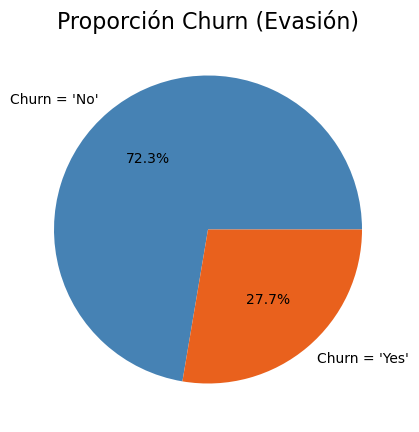

In [20]:
# Visualizar la proporción de registros en relación a la evasión (Churn)
churns = df.groupby('Churn')['Churn'].value_counts()
churns = pd.DataFrame(churns)
fig, ax = plt.subplots(figsize=(6,5))
ax = plt.pie(data=churns,
             x=churns['count'],
             labels=["Churn = 'No'", "Churn = 'Yes'"],
             autopct='%1.1f%%',
             colors=churn_colors)

plt.title('Proporción Churn (Evasión)', fontsize=16)

fig.savefig(IMG_PATH/'pie_Churn_proportion.png',
            transparent=False,
            dpi=300,
            bbox_inches='tight')
plt.show()

Como puede verse en el gráfico, la proporción de las clases está desbalanceada, con aproximadamente 3/4 de los datos correspondiente a clientes que no han abandonado la empresa. Por lo tanto, para que el modelo pueda generalizar correctamente el patrón presente en los datos, será necesario reducir la cantidad de registros para equiparar las observaciones de cada clase.

In [21]:
columnas = df.columns
columnas, len(columnas)

(Index(['Gender_Male', 'SeniorCitizen_Yes', 'Partner_Yes', 'Dependents_Yes',
        'PhoneService_Yes', 'MultipleLines_Yes', 'InternetService_DSL',
        'InternetService_Fiber optic', 'NoInternetService',
        'OnlineSecurity_Yes', 'OnlineBackup_Yes', 'DeviceProtection_Yes',
        'TechSupport_Yes', 'StreamingTV_Yes', 'StreamingMovies_Yes',
        'Contract_Month-to-month', 'Contract_One year', 'Contract_Two year',
        'PaperlessBilling_Yes', 'PaymentMethod_Bank transfer (automatic)',
        'PaymentMethod_Credit card (automatic)',
        'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
        'Tenure', 'ChargesMonthly', 'ChargesTotal', 'Churn'],
       dtype='object'),
 27)

In [22]:
undersampler = NearMiss(version=3)

X_balanced, y_balanced = undersampler.fit_resample(X,y)

In [23]:
X_balanced.shape, y_balanced.shape

((3956, 26), (3956,))

In [24]:
df1 = pd.DataFrame(X_balanced, columns=columnas[:-1])
df2 = pd.DataFrame(y_balanced, columns=[columnas[-1]])
df = pd.concat([df1, df2], axis=1)
df

,Gender_Male,SeniorCitizen_Yes,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,NoInternetService,OnlineSecurity_Yes,...,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Tenure,ChargesMonthly,ChargesTotal,Churn
0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,...,1.0,1.0,0.0,1.0,0.0,0.0,72.0,116.95,8594.40,0
1,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,72.0,117.50,8670.10,0
2,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,...,1.0,1.0,1.0,0.0,0.0,0.0,72.0,118.75,8672.45,0
3,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,...,1.0,1.0,1.0,0.0,0.0,0.0,72.0,110.30,7966.90,0
4,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,1.0,0.0,0.0,72.0,110.60,7962.20,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3951,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,16.0,72.65,1194.30,1
3952,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,2.0,19.60,35.85,1
3953,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,24.0,76.10,1712.70,1
3954,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,15.0,101.10,1504.05,1


## Normalización de datos

Si bien algunos modelos como `Random Forest` no necesitan normalización (ya que este no se basa en distancias, sino en preguntas de comparación: < o > ), se analizarán las variables numéricas, ya que la idea del proyecto es probar distintos modelos y evaluarlos para así seleccionar el que tenga mejor desempeño para ponerlo en producción.

In [25]:
def bin_width(df, columna):
    n = df.shape[0]
    iqr = df[columna].quantile(0.75) - df[columna].quantile(0.25) 
    
    bin_width = 2 * (iqr / np.cbrt(n))
    return bin_width

<Axes: xlabel='Tenure', ylabel='Count'>

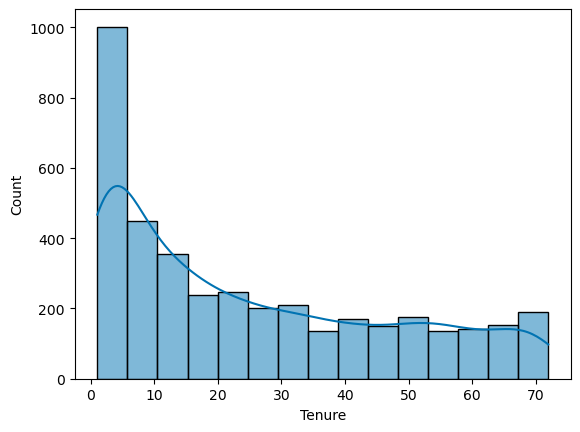

In [26]:
BIN_WIDTH = bin_width(df, 'Tenure')

sns.histplot(df['Tenure'], binwidth=BIN_WIDTH, kde=True)

<Axes: xlabel='ChargesMonthly', ylabel='Count'>

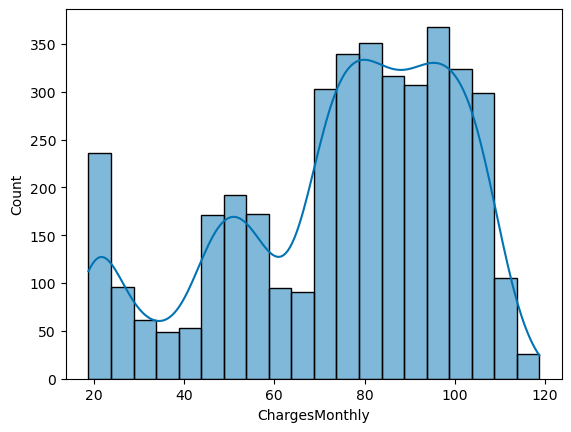

In [27]:
BIN_WIDTH = bin_width(df, 'ChargesMonthly')

sns.histplot(df['ChargesMonthly'], binwidth=BIN_WIDTH, kde=True)

<Axes: xlabel='ChargesTotal', ylabel='Count'>

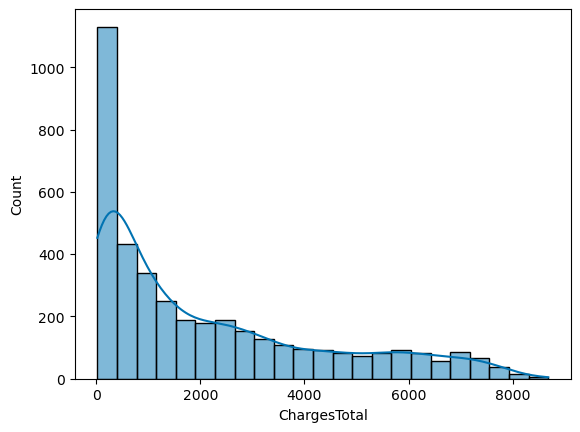

In [28]:
BIN_WIDTH = bin_width(df, 'ChargesTotal')

sns.histplot(df['ChargesTotal'], binwidth=BIN_WIDTH, kde=True)

In [29]:
df['log_ChargesTotal'] = np.log(df['ChargesTotal'] + 1)

<Axes: xlabel='log_ChargesTotal', ylabel='Count'>

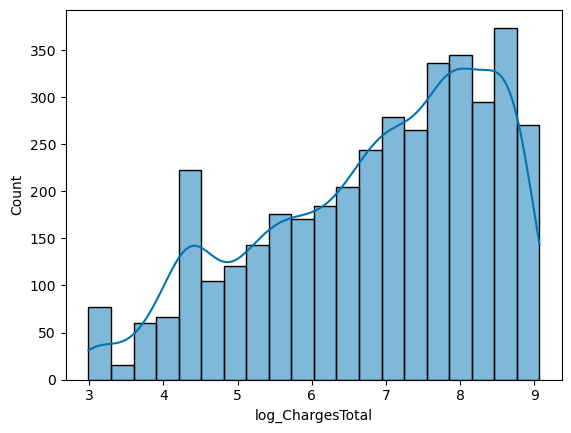

In [30]:
BIN_WIDTH = bin_width(df, 'log_ChargesTotal')

sns.histplot(df['log_ChargesTotal'], binwidth=BIN_WIDTH, kde=True)

In [31]:
df['sqrt_ChargesTotal'] = np.sqrt(df['ChargesTotal'] + 1)

<Axes: xlabel='sqrt_ChargesTotal', ylabel='Count'>

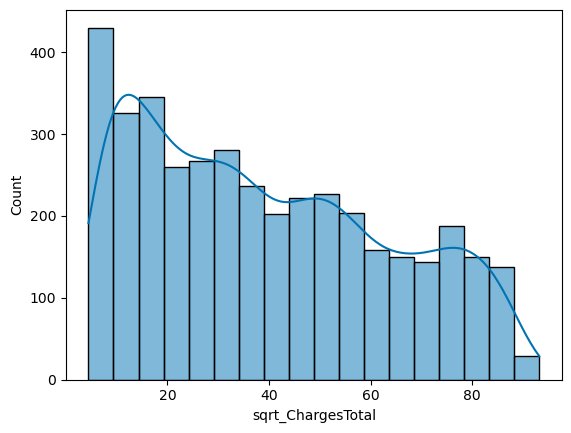

In [32]:
BIN_WIDTH = bin_width(df, 'sqrt_ChargesTotal')

sns.histplot(df['sqrt_ChargesTotal'], binwidth=BIN_WIDTH, kde=True)

In [33]:
scaler = StandardScaler()

In [34]:
df['Z_ChargesTotal'] = scaler.fit_transform(df[['ChargesTotal']])

<Axes: xlabel='Z_ChargesTotal', ylabel='Count'>

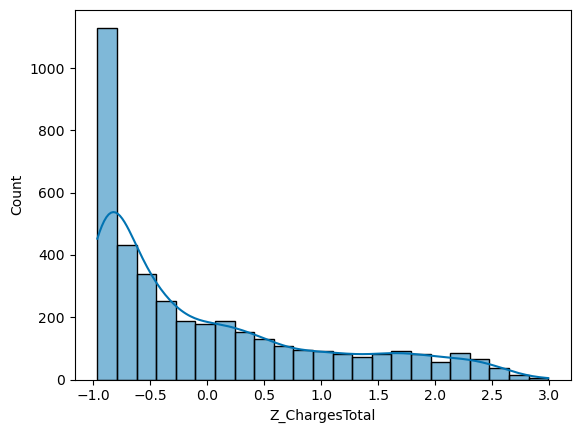

In [35]:
BIN_WIDTH = bin_width(df, 'Z_ChargesTotal')

sns.histplot(df['Z_ChargesTotal'], binwidth=BIN_WIDTH, kde=True)

### Observaciones: Normalización de datos

Es posible observar que ninguna de las transformaciones aplicadas consigue corregir la asimetría positiva de ChargesTotal.
Debido a su naturaleza acumulativa, se puede esperar de este tipo de variables que la mayor concentración de observaciones se encuentre en valores pequeños, teniendo solo valores altos por ejemplo, para un grupo seleccionado de clientes.
En adición, fueron incluidos los registros considerados outliers (clientes de alto valor que abandonaron la empresa), ya que resulta importante conocer que características comparten estos con aquellos de "menor valor", lo que indicará **áreas críticas de mejora para reducir la tasa de Evación *(Churn)***.

Por lo tanto optaré por mantener las variables cuantitativas en su estado original y evaluar si los modelos son capaces de manejarlas correctamente. Caso contrario, aplicaré `MinMaxScaler`

In [36]:
df = df.drop(['log_ChargesTotal', 'sqrt_ChargesTotal', 'Z_ChargesTotal'], axis=1)

In [37]:
#normalizer = MinMaxScaler()

#df['Tenure'] = normalizer.fit_transform(df[['Tenure']])
#df['ChargesMonthly'] = normalizer.fit_transform(df[['ChargesMonthly']])
#df['ChargesTotal'] = normalizer.fit_transform(df[['ChargesTotal']])

In [38]:
df.describe()

,Gender_Male,SeniorCitizen_Yes,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,NoInternetService,OnlineSecurity_Yes,...,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Tenure,ChargesMonthly,ChargesTotal,Churn
count,3956.000000,3956.000000,3956.000000,3956.000000,3956.000000,3956.000000,3956.000000,3956.000000,3956.000000,3956.000000,...,3956.000000,3956.000000,3956.000000,3956.000000,3956.000000,3956.000000,3956.000000,3956.000000,3956.000000,3956.000000
mean,0.505056,0.215369,0.427199,0.233822,0.915066,0.469161,0.301062,0.627149,0.071790,0.251011,...,0.096562,0.691608,0.180485,0.173660,0.460819,0.185035,25.162032,74.844843,2126.464130,0.500000
std,0.500038,0.411130,0.494734,0.423314,0.278819,0.499111,0.458777,0.483624,0.258172,0.433650,...,0.295398,0.461888,0.384640,0.378865,0.498525,0.388375,21.994213,25.315958,2192.434299,0.500063
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,18.800000,18.850000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,56.037500,305.550000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,18.000000,79.875000,1238.150000,0.500000
75%,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,...,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,42.000000,94.850000,3307.450000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,72.000000,118.750000,8684.800000,1.000000


In [39]:
df.shape

(3956, 27)

In [40]:
X = df.drop('Churn', axis=1)
y = df['Churn']

# 4. Modelado de datos

## Baseline model

In [41]:
X, X_test, y, y_test = tts(X, y, test_size=0.15, stratify=y, random_state=42)

In [42]:
X.shape

(3362, 26)

In [43]:
X_train, X_val, y_train, y_val = tts(X, y, test_size=0.117, stratify=y, random_state=42)

In [44]:
kf = KFold(n_splits=6, shuffle=True, random_state=42)

In [45]:
baseline_model = DecisionTreeClassifier(random_state=42)

In [46]:
baseline_results = cross_validate(baseline_model, X, y, cv=kf)
baseline_results

{'fit_time': array([0.03723645, 0.03790474, 0.0376482 , 0.03710508, 0.03817797,
        0.03780746]),
 'score_time': array([0.00504208, 0.00380969, 0.00439382, 0.00331092, 0.00249004,
        0.00333667]),
 'test_score': array([0.64527629, 0.65953654, 0.62321429, 0.60357143, 0.63214286,
        0.66071429])}

In [47]:
baseline_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [48]:
baseline_pred = baseline_model.predict(X_val)

In [49]:
print(classification_report(y_val, baseline_pred))

              precision    recall  f1-score   support

           0       0.67      0.59      0.63       197
           1       0.64      0.71      0.67       197

    accuracy                           0.65       394
   macro avg       0.65      0.65      0.65       394
weighted avg       0.65      0.65      0.65       394



In [50]:
confmat = confusion_matrix(y_val, baseline_pred)

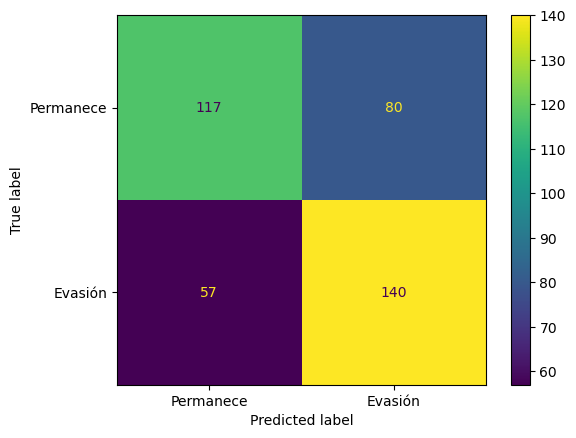

In [51]:
viz_confmat = ConfusionMatrixDisplay(confusion_matrix=confmat, display_labels=['Permanece', 'Evasión'])
viz_confmat.plot()

In [55]:
# Crear una lista para almacenar los resultados de los modelos y poder realizar comparaciones.
results_tracking = []

In [56]:
baseline_results = metricas_generales(baseline_model, X_val, y_val, 'Baseline Model')

In [57]:
baseline_results

{'Model': 'Baseline Model',
 'Accuracy': 0.6523,
 'Precision': 0.6364,
 'Recall': 0.7107,
 'F1-score': 0.6715}

## Observaciones: Baseline Model

El resultado del modelo inicial es bastante aceptable, fue entrenado sin ningún hiperparámetro para utilizarlo como base.
* **Exactitud (Accuracy) = 65.23%**.
$$
Accuracy = \frac{TP + TN}{TP+TN+FP+FN}
$$
* El modelo demuestra un mejor desempeño al identificar correctamente a los clientes que efectivamente abandonan, ya que el **Recall (Sensibilidad)** del modelo tiene un valor de **71.07%**, es decir, el ratio de verdaderos positivos sobre el total de positivos reales:
$$
Recall = \frac{TP}{TP+FN}
$$
* Mientras que la **Precisión (Precision)** tiene un valor de **63.64%**.
$$
Precision = \frac{TP}{TP+FP}
$$
Dado que el objetivo principal es identificar proactivamente a los clientes en riesgo de abandonar, se prioriza el Recall. No obstante, para evitar acciones innecesarias hacia clientes que no se darían de baja, también se considera **el F1-score**, una métrica que combina ambas dimensiones:
$$
\text{F1-score} = 2*\frac{Recall * Precision}{Recall + Precision}
$$

**El objetivo será, por tanto, maximizar la sensibilidad sin sacrificar excesivamente la precisión, para lograr intervenciones eficaces y eficientes.**

In [58]:
results_tracking.append(baseline_results)

In [59]:
# Para comprobar el ajuste del entrenamiento del modelo base:
train_preds = baseline_model.predict(X_train)
print(classification_report(y_train, train_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1484
           1       1.00      1.00      1.00      1484

    accuracy                           1.00      2968
   macro avg       1.00      1.00      1.00      2968
weighted avg       1.00      1.00      1.00      2968



Es posible ver que el modelo memorizó el patrón en los datos de entrenamiento, devolviendo 100% en todas las métricas. Sin embargo, al generalizar en datos de validación, alcanzo un 65% de Exactitud.

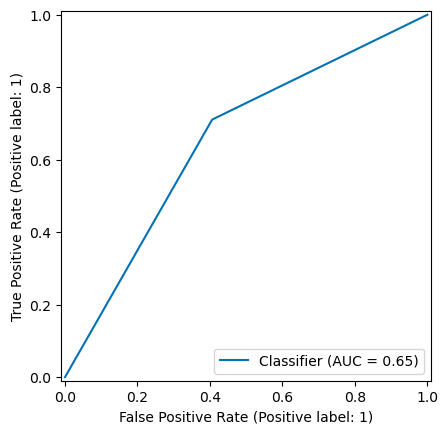

In [61]:
RocCurveDisplay.from_predictions(y_val, baseline_pred);

## Random Forest Classifier

### RandomForest 1 - MaxDepth = 10

In [62]:
modelo_1 = RandomForestClassifier(max_depth=10, random_state=42) 

In [63]:
modelo_1.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, random_state=42)

In [66]:
modelo_1_preds = modelo_1.predict(X_val)
print(classification_report(y_val, modelo_1_preds))

              precision    recall  f1-score   support

           0       0.70      0.65      0.68       197
           1       0.67      0.72      0.69       197

    accuracy                           0.69       394
   macro avg       0.69      0.69      0.68       394
weighted avg       0.69      0.69      0.68       394



In [64]:
modelo_1_results = metricas_generales(modelo_1, X_val, y_val, 'RandomForest 1')
modelo_1_results

{'Model': 'RandomForest 1',
 'Accuracy': 0.6853,
 'Precision': 0.6746,
 'Recall': 0.7157,
 'F1-score': 0.6946}

In [67]:
baseline_results

{'Model': 'Baseline Model',
 'Accuracy': 0.6523,
 'Precision': 0.6364,
 'Recall': 0.7107,
 'F1-score': 0.6715}

### Observaciones RandomForest 1

Este modelo de ensamble consigue mejorar levemente el Recall (Sensibilidad) en un 0.5%. Pero con una mejor generalización.

* La exactitud del modelo mejora aproximadamente **3.3%**
* La Precisión del modelo mejora aproximadamente **4%**

Como se mencionó anteriormente, el **F1-score** es una métrica que combina las dimensiones de Recall y Precisión. Al obtener, mejora en ambas métricas, podemos observar como este también obtiene una mejora de aproximadamente **2.3%**.

Por lo tanto, el ensamble de diversos árboles de decisión permite una mejor generalización del patrón contenido en los datos por parte del modelo. Por lo que este será el modelo que se busque mejorar

Se ejecutará un Grid Search para definir los hiperparámetros que mejor se ajusten al modelo, una vez obtenidos, se entrenará el mejor modelo posible para evaluar sus resultados.